# Capstone Project
## Probabilistic generative models
### Instructions

In this notebook, you will practice working with generative models, using both normalising flow networks and the variational autoencoder algorithm. You will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and you will used the trained model to interpolate between the generated images. You will use concepts from throughout this course, including Distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports below. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Conv2D, Conv2DTranspose,
                                     BatchNormalization, ReLU, LeakyReLU)

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import math
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import seaborn as sns

![Flags overview image](data/example_images.png)

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$. 
* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution. 
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [3]:
def plot_scatt(samples, title, xlim = (-1,1), ylim = (-1,1)):
    plt.scatter(samples[:,0], samples[:,1], alpha=0.3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)

In [4]:
loc = [0,0]
scale_diag = [0.3, 0.3]
base_dist = tfd.MultivariateNormalDiag(loc = loc, scale_diag = scale_diag)

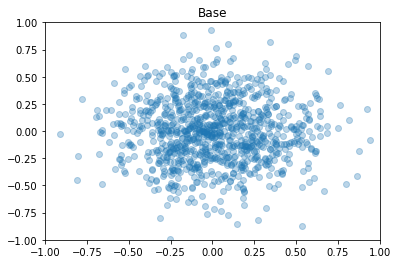

In [5]:

plot_scatt(base_dist.sample(1000), 'Base')

In [6]:
theta_dist = tfd.Uniform(0, 2*math.pi)
a_dist = tfd.Normal(3, 1)

In [7]:
class SquareMultiplyAdd(tfb.Bijector):
    def __init__(self, a, validate_args = False, name = 'SquareMultiplyAdd'):
        self.a = tf.cast(a, tf.float32)
        super(SquareMultiplyAdd, self).__init__(validate_args, validate_args,
                                               forward_min_event_ndims = 1, name = name)
        
    def forward(self, x):
        x = tf.cast(x, tf.float32)
        y = tf.concat([x[...,:1], self.a * tf.square(x[...,:1]) + x[...,1:]], axis = -1)
        return y
    
    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        x = tf.concat([y[...,:1], y[...,1:] - self.a * tf.square(y[...,:1])], axis = -1)
        return x
    
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0, dtype = x.dtype)

In [8]:
class Rotation(tfb.Bijector):
    def __init__(self, theta, validate_args = False, name = 'Rotation'):
        self.rot_mat = tf.convert_to_tensor([[tf.cos(theta), -tf.sin(theta)],
                                            [tf.sin(theta), tf.cos(theta)]], dtype = tf.float32)
        super(Rotation, self).__init__(validate_args, validate_args,
                                               forward_min_event_ndims = 1, name = name)
        
    def forward(self, x):
        return tf.linalg.matvec(self.rot_mat, x)
    
    def _inverse(self, y):
        return tf.linalg.matvec(tf.transpose(self.rot_mat), y)
    
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0, dtype = x.dtype) 

In [9]:
def get_transformed_dist(base_dist, a, theta):
    flow = tfb.Chain([
        tfb.Tanh(),
        Rotation(theta),
        SquareMultiplyAdd(a),
        tfb.Scale([1, 0.5]),
        tfb.Shift([0, -2])
    ])
    
    trans_dist = tfd.TransformedDistribution(base_dist, flow)
    
    return flow, trans_dist

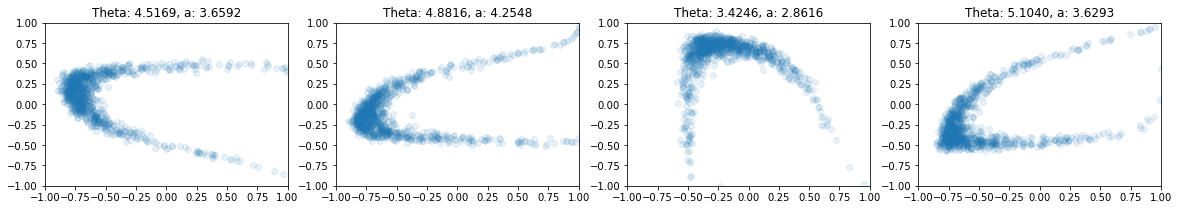

In [10]:
plt.rcParams["figure.figsize"] = (20,3)
for i, (a, theta) in enumerate(zip(a_dist.sample(4), theta_dist.sample(4))):
    plt.subplot(1,4, i+1)
    _, trans_dist = get_transformed_dist(base_dist, a, theta)
    sample = trans_dist.sample(1000)
    plt.scatter(sample[:,0], sample[:,1], alpha = 0.1)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.title('Theta: {:.4f}, a: {:.4f}'.format(theta, a))
plt.show()

## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network. 
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters. 
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot. 
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset. 
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [11]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [69]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.85, 0.8))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot[3:39,22:58,:]

In [70]:
def get_contour(base_dist, a, theta):
    _, trans_dist = get_transformed_dist(base_dist, a, theta)
    trans_dist = tfd.BatchReshape(trans_dist, [1])
    Z = get_densities(trans_dist).squeeze()
    return get_image_array_from_density_values(Z)

In [71]:
image = get_contour(base_dist, a_dist.sample(1), theta_dist.sample(1))
image.shape

(36, 36, 3)

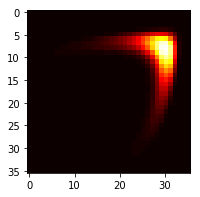

In [74]:
plt.imshow(image)

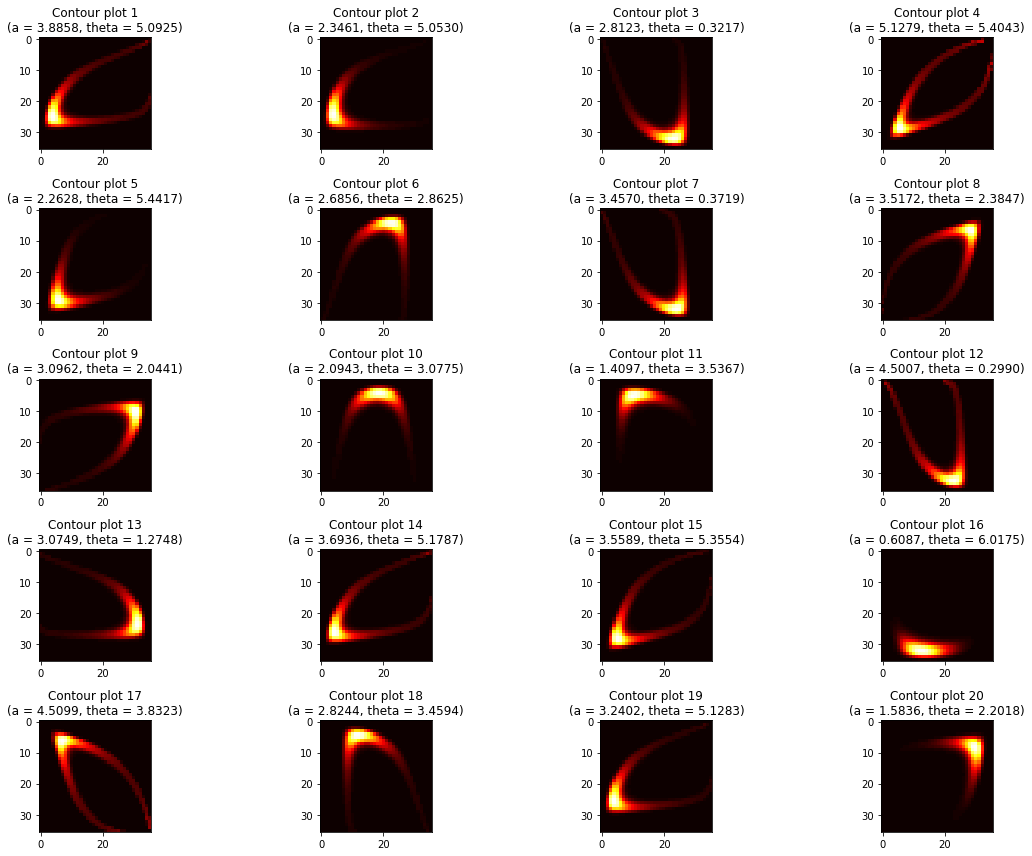

In [73]:
n_ax_rows, n_ax_cols = 5, 4
n_transformed_dists = 20

fig, ax = plt.subplots(n_ax_rows, n_ax_cols, figsize=(16, 12))
for i, (a, theta) in enumerate(zip(a_dist.sample(n_transformed_dists), theta_dist.sample(n_transformed_dists))):
    _, transformed_dist = get_transformed_dist(base_dist, a, theta)
    transformed_dist = tfd.BatchReshape(transformed_dist, [1])
    Z = get_densities(transformed_dist).squeeze()
    image = get_image_array_from_density_values(Z)
    ax[i // n_ax_cols, i % n_ax_cols].imshow(image)
    ax[i // n_ax_cols, i % n_ax_cols].set_title(
        'Contour plot {:d}\n(a = {:.4f}, theta = {:.4f})'.format(i+1, a, theta)
    )
    ax[i // n_ax_cols, i % n_ax_cols].set_aspect('equal', 'box')

fig.tight_layout()

In [75]:
images = []
for a, theta in zip(a_dist.sample(1000), theta_dist.sample(1000)):
    images.append(get_contour(base_dist, a, theta))
    
images = np.stack(images)
print('Shape of images: ', images.shape)

Shape of images:  (1000, 36, 36, 3)


## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [76]:
img_train, img_val = train_test_split(images, test_size = 0.15)
print('Shape of images train: ', img_train.shape)
print('Shape of images val: ', img_val.shape)

Shape of images train:  (850, 36, 36, 3)
Shape of images val:  (150, 36, 36, 3)


In [77]:
def generateTFDataset(array, batch_size=20, buffer_size=100000):
    img_array = np.array(array, dtype=np.float32)
    dataset = tf.data.Dataset.from_tensor_slices(img_array)
    dataset = dataset.map(lambda x: (x/255., x/255.))
    dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [78]:
train = generateTFDataset(img_train)
val = generateTFDataset(img_val)


In [80]:
print('Training dataset element spec:\n', train.element_spec)

Training dataset element spec:
 (TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [81]:
dim_latent = 2
prior = tfd.MultivariateNormalDiag(loc = tf.zeros(dim_latent),
                                  scale_diag = tf.ones(dim_latent))

In [90]:
encoder = Sequential([
    Conv2D(32, (3,3), strides = 2, padding = 'same', input_shape = (36, 36, 3)),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(64, (3,3), strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(tfpl.MultivariateNormalTriL.params_size(dim_latent)),  # no activation function
    tfpl.MultivariateNormalTriL(
        dim_latent,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
    )
])
encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 18, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5184)             

In [96]:
decoder = Sequential([
    Dense(256, activation = 'relu', input_shape = (dim_latent, )),
    Dense(81*64, activation = 'relu'),
    Reshape((9,9,64)),
    Conv2DTranspose(32, (3,3), strides = 2, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2DTranspose(3, (3,3), strides = 2, padding = 'same'),
    Flatten(),
    tfpl.IndependentBernoulli((36,36,3))
])
decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_15 (Dense)             (None, 5184)              1332288   
_________________________________________________________________
reshape_4 (Reshape)          (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 18, 18, 32)        18464     
_________________________________________________________________
batch_normalization_10 (Batc (None, 18, 18, 32)        128       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 36, 36, 3)        

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [97]:
vae = Model(encoder.input, decoder(encoder.output))
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 18, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 9, 9, 64)          0   

In [98]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
nll_loss = lambda x_true, x_pred: -tf.reduce_sum(x_pred.log_prob(x_true))
vae.compile(optimizer=optimizer, loss=nll_loss)

In [101]:
history = vae.fit(train, validation_data = val, epochs = 30)

Train for 42 steps, validate for 7 steps
Epoch 1/30
42/42 [==============================] - 11s 259ms/step - loss: 12746.4525 - val_loss: 23729.8234
Epoch 2/30
42/42 [==============================] - 11s 264ms/step - loss: 11168.5130 - val_loss: 18365.8677
Epoch 3/30
42/42 [==============================] - 11s 259ms/step - loss: 10307.1315 - val_loss: 15158.3869
Epoch 4/30
42/42 [==============================] - 11s 262ms/step - loss: 9862.3679 - val_loss: 13313.8344
Epoch 5/30
42/42 [==============================] - 11s 264ms/step - loss: 9469.6469 - val_loss: 11557.0498
Epoch 6/30
42/42 [==============================] - 11s 267ms/step - loss: 9251.3785 - val_loss: 10824.0112
Epoch 7/30
42/42 [==============================] - 11s 262ms/step - loss: 9028.8873 - val_loss: 9977.4290
Epoch 8/30
42/42 [==============================] - 11s 262ms/step - loss: 8888.3803 - val_loss: 9491.7701
Epoch 9/30
42/42 [==============================] - 11s 257ms/step - loss: 8774.3745 - val_los

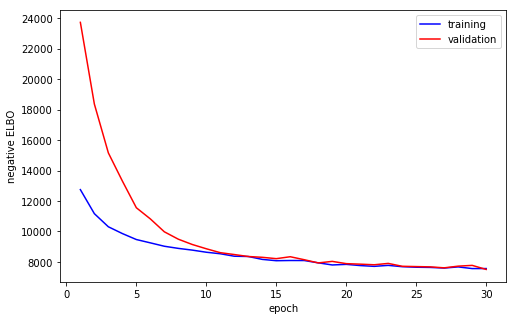

In [104]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(30)+1, history.history['loss'], 'b', label='training')
plt.plot(np.arange(30)+1, history.history['val_loss'], 'r', label='validation')
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.legend()
plt.show()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

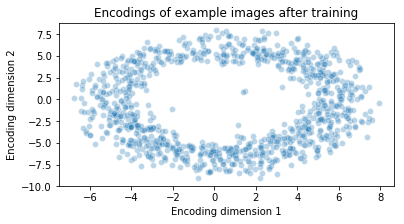

In [107]:
enc_dist = encoder(images/255.)
sns.scatterplot(enc_dist[:,0], enc_dist[:,1], alpha=0.3)
plt.title('Encodings of example images after training');
plt.xlabel('Encoding dimension 1')
plt.ylabel('Encoding dimension 2')
plt.show()

In [108]:
def reconstruct(encoder, decoder, images):
    enc_dist = encoder(images)
    z_mean = enc_dist.mean()
    dec_dist = decoder(z_mean)
    return dec_dist.mean()

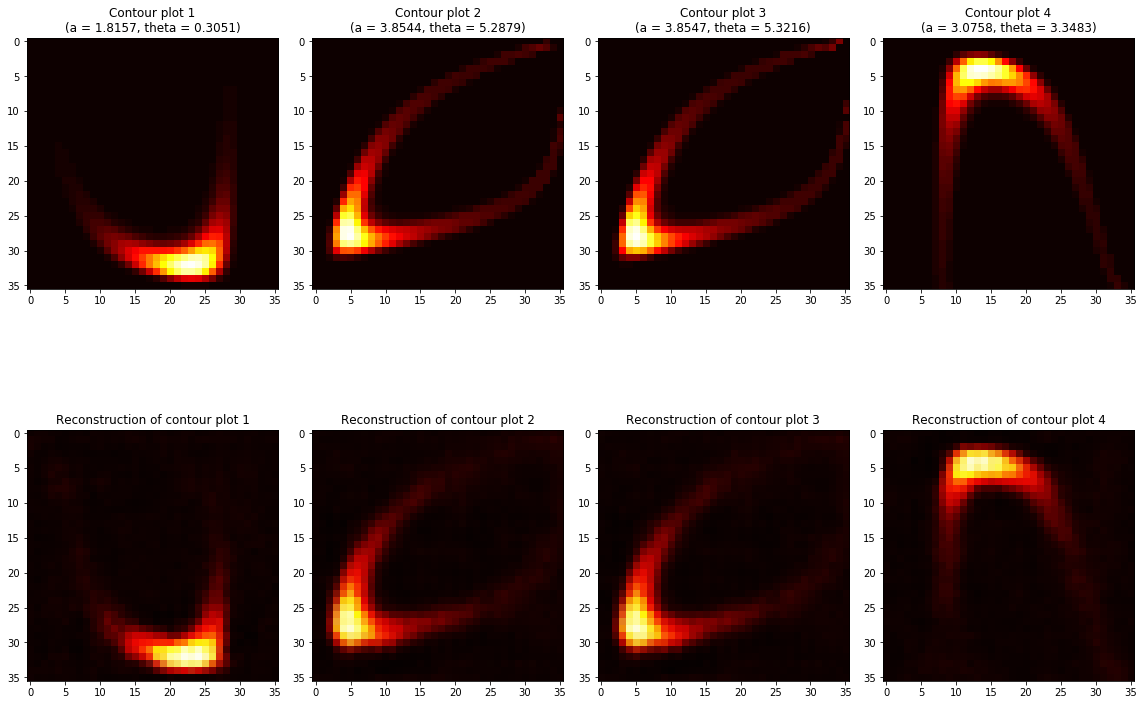

In [109]:
n_transformed_dists = 4

fig, ax = plt.subplots(2, n_transformed_dists, figsize=(16, 12))
for i, (a, theta) in enumerate(zip(a_dist.sample(n_transformed_dists), theta_dist.sample(n_transformed_dists))):
    image = get_contour(base_dist, a, theta)
    ax[0, i % n_transformed_dists].imshow(image / 255.0)
    ax[0, i % n_transformed_dists].set_title(
        'Contour plot {:d}\n(a = {:.4f}, theta = {:.4f})'.format(i+1, a, theta)
    )
    ax[0, i % n_transformed_dists].set_aspect('equal', 'box')
    ax[1, i % n_transformed_dists].imshow(
        tf.squeeze(reconstruct(encoder, decoder, tf.expand_dims(image / 255.0, axis=0)))
    )
    ax[1, i % n_transformed_dists].set_title('Reconstruction of contour plot {:d}'.format(i+1))
    ax[1, i % n_transformed_dists].set_aspect('equal', 'box')

fig.tight_layout()

shape of z: (6, 2)
generated_images_dist:
 tfp.distributions.Independent("sequential_7_independent_bernoulli_4_IndependentBernoulli_Independentsequential_7_independent_bernoulli_4_IndependentBernoulli_Bernoulli", batch_shape=[6], event_shape=[36, 36, 3], dtype=float32)
shape of generated_images: (6, 36, 36, 3)


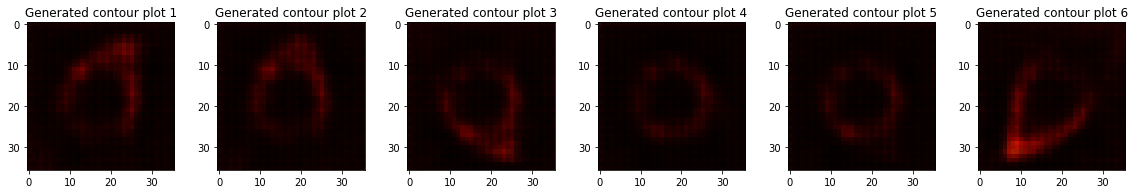

In [110]:
n_z_samples = 6

z = prior.sample(n_z_samples)
print('shape of z:', z.shape)

generated_images_dist = decoder(z)
print('generated_images_dist:\n', generated_images_dist)

generated_images = generated_images_dist.mean()
print('shape of generated_images:', generated_images.shape)

fig, ax = plt.subplots(1, n_z_samples, figsize=(16, 12))

for i in range(n_z_samples):
    ax[i].imshow(generated_images[i])
    ax[i].set_title('Generated contour plot {:d}'.format(i+1))
    ax[i].set_aspect('equal', 'box')

fig.tight_layout()

## Make a video of latent space interpolation (not assessed)
* Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [111]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

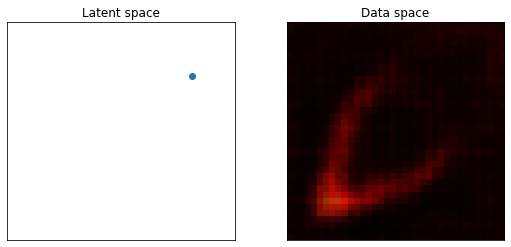

In [113]:
# Create the animation

a = get_animation(2, decoder, interpolation_length=200)
HTML(a.to_html5_video())